# **LAYER VISUALIZATION OF UNDERWATER IMAGING**

Date - 19/08/2023

In [1]:
import os
import random
import csv

In [2]:
import cv2
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import random


import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Concatenate, GlobalAveragePooling2D, Multiply,GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

2023-08-20 20:44:14.459130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 20:44:14.690710: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-20 20:44:14.724444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pamudu/anaconda3/envs/TeaRetina/lib/python3.9/site-packages/cv2/../../lib64:


In [3]:
# Load custom Function
import image_padding
import CBAM_attention

In [4]:
# set Radndom Seed
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(True)

#### **LOAD DATA**

In [5]:
# Load train test validation image paths form csv files 
def load_excel_data(file_path, column1_name='UnderWater Images', column2_name='GroundTruth Images', sheet_name="Sheet1"):
    try:
        # Load the Excel file
        df = pd.read_csv(file_path)

        # Extract the data from the specified columns
        column1_data = df[column1_name].tolist()
        column2_data = df[column2_name].tolist()

        return column1_data, column2_data

    except Exception as e:
        print(f"Error occurred while loading data from Excel: {e}")
        return None, None

In [6]:
train_csv_path = r'Datasets/test.csv'
test_csv_path = r'Datasets/train.csv'
validation_csv_path = r'Datasets/validation.csv'

In [7]:
train_x_paths, train_y_paths = load_excel_data(train_csv_path)
val_x_paths, val_y_paths = load_excel_data(validation_csv_path)
test_x_paths, test_y_paths = load_excel_data(test_csv_path)

In [8]:
train_x_paths = sorted(train_x_paths)
train_y_paths = sorted(train_y_paths)
val_x_paths = sorted(val_x_paths)
val_y_paths = sorted(val_y_paths)
test_x_paths = sorted(test_x_paths)
test_y_paths = sorted(test_y_paths)

In [9]:
print(f'X_train : {len(train_x_paths)}')
print(f'Y_train : {len(train_y_paths)}')
print(f'X_val   : {len(val_x_paths)}')
print(f'Y_val   : {len(val_y_paths)}')
print(f'X_test  : {len(test_x_paths)}')
print(f'Y_test  : {len(test_y_paths)}')

X_train : 1144
Y_train : 1144
X_val   : 1143
Y_val   : 1143
X_test  : 9148
Y_test  : 9148


### **Load Pre-trained Model**

In [10]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_model(input_shape):
    inputs = Input(input_shape)

    vgg_model = VGG16(include_top=False, weights="imagenet",input_tensor=inputs)
    vgg_model.trainable = False

    # Encoder
    s1 = vgg_model.get_layer("block1_conv2").output                             ## (512 x 512)
    s2 = vgg_model.get_layer("block2_conv2").output                             ## (256 x 256)
    s3 = vgg_model.get_layer("block3_conv3").output                             ## (128 x 128)
    s4 = vgg_model.get_layer("block4_conv3").output                             ## (64 x 64)

    b1 = vgg_model.get_layer("block5_conv3").output                             ## (32 x 32)

    # Attention
    s1 = CBAM_attention.CBAM(s1)
    s2 = CBAM_attention.CBAM(s2)
    s3 = CBAM_attention.CBAM(s3)
    s4 = CBAM_attention.CBAM(s4)

    # Decoder
    d1 = decoder_block(b1, s4, 512)                                             ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                                             ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                                             ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                                              ## (512 x 512)

    # Output
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="LLE_UNET_undwerwater")
    return model


In [11]:
input_shape = (None, None, 3)
model = build_model(input_shape)
model.summary()

2023-08-20 20:44:16.845839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pamudu/anaconda3/envs/TeaRetina/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-20 20:44:16.845868: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-20 20:44:16.845885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PK-ASUS-EXPERTBOOK-B1500CEAEY-B1500CEAE): /proc/driver/nvidia/version does not exist
2023-08-20 20:44:16.846435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them 

Model: "LLE_UNET_undwerwater"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                            

In [12]:
# save model as png
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
MSEloss = tf.keras.losses.MeanSquaredError()

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_loss_fn(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=1.0)

def ssim_loss_fn(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [14]:
# Load model weights
model_path = r'LLE_WEIGHTS/LLE_UNET_UNDWERWATER.h5'

In [15]:
from keras.models import load_model
model = load_model(model_path,custom_objects={'charbonnier_loss': charbonnier_loss,
                                              'psnr_loss_fn':psnr_loss_fn,
                                              'ssim_loss_fn':ssim_loss_fn},
                                              compile = False)

#### **Preprocessing Functions**

In [16]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    preprocess_img = image_padding.pad_image(img)
    preprocess_img = preprocess_img/255;
    return preprocess_img

### **Filter Visualization**

To understand the filters in the model 

block2_conv1 : (3, 3, 64, 128)


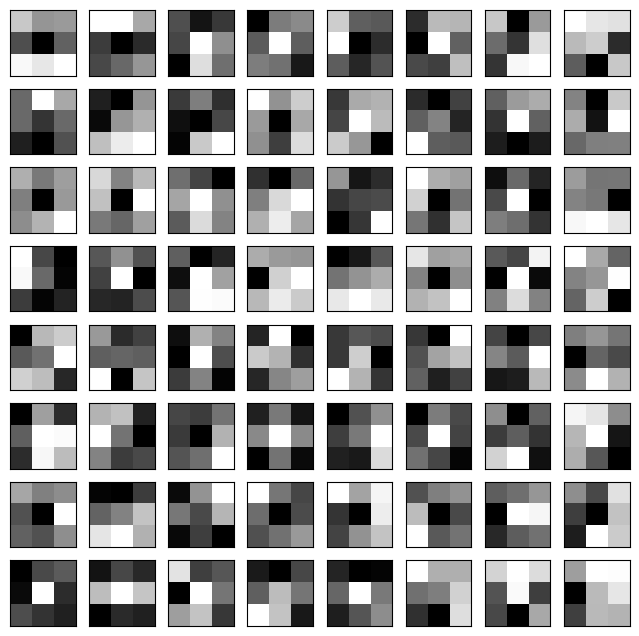

In [17]:
LAYER_IDX = 4   ## change this and see the different filters

layer_names = model.layers
if 'conv' in layer_names[LAYER_IDX].name:
    filters, biases = model.layers[LAYER_IDX].get_weights()

    print(f'{layer_names[LAYER_IDX].name} : {filters.shape}')

    ## Plot figure
    fig = plt.figure(figsize=(8, 8))
    columns = 8
    rows    = 8

    n_filters = columns * rows
    for i in range(1, n_filters +1):
        filter = filters[:, :, :, i-1]
        fig = plt.subplot(rows, columns, i)
        
        #turn off axis
        fig.set_xticks([])  
        fig.set_yticks([])
        plt.imshow(filter[:, :, 0], cmap='gray') # Show only the filters from 0th channel (R)
    plt.show() 
else:
    print(f'Layer {LAYER_IDX} not have convolution filters')

#### Rebuild model with selected layers to visualize

In [18]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)


['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'global_average_pooling2d_3', 'global_max_pooling2d_3', 'dense_6', 'dense_7', 'tf.__operators__.add_3', 'activation_3', 'multiply_6', 'block4_pool', 'tf.math.reduce_mean_3', 'tf.math.reduce_max_3', 'block5_conv1', 'tf.expand_dims_6', 'tf.expand_dims_7', 'block5_conv2', 'concatenate_3', 'global_average_pooling2d_2', 'global_max_pooling2d_2', 'block5_conv3', 'conv2d_3', 'dense_4', 'conv2d_transpose', 'multiply_7', 'dense_5', 'concatenate_4', 'tf.__operators__.add_2', 'conv2d_4', 'activation_2', 'batch_normalization', 'multiply_4', 'activation_4', 'tf.math.reduce_mean_2', 'tf.math.reduce_max_2', 'conv2d_5', 'tf.expand_dims_4', 'tf.expand_dims_5', 'batch_normalization_1', 'concatenate_2', 'global_average_pooling2d_1', 'global_max_pooling2d_1', 'activation_5', 'conv2d_2', 'dens

In [19]:
# The Encoder Layers want to Visualize
selected_encoder_layers = ['block1_conv2', 'block1_pool', 'block2_conv2', 'block2_pool',
                           'block3_conv3', 'block3_pool', 'block4_conv3', 'block4_pool',
                           'block5_conv3']

In [20]:
# The Decoder Layers want to Visualize
# Select "conv_transpose" layers and "concatenate" layers

layer_names = [layer.name for layer in model.layers]

selected_decoder_layers = []
for layer_name in layer_names:
    if "transpose" in layer_name or "concatenate" in layer_name:
        selected_decoder_layers.append(layer_name)

print(selected_decoder_layers)

['concatenate_3', 'conv2d_transpose', 'concatenate_4', 'concatenate_2', 'conv2d_transpose_1', 'concatenate_5', 'concatenate_1', 'conv2d_transpose_2', 'concatenate_6', 'concatenate', 'conv2d_transpose_3', 'concatenate_7']


In [21]:
## combine encoder layer names and decoder layer names that we want to visualize
selected_layers = selected_encoder_layers + selected_decoder_layers

In [22]:
selected_layers

['block1_conv2',
 'block1_pool',
 'block2_conv2',
 'block2_pool',
 'block3_conv3',
 'block3_pool',
 'block4_conv3',
 'block4_pool',
 'block5_conv3',
 'concatenate_3',
 'conv2d_transpose',
 'concatenate_4',
 'concatenate_2',
 'conv2d_transpose_1',
 'concatenate_5',
 'concatenate_1',
 'conv2d_transpose_2',
 'concatenate_6',
 'concatenate',
 'conv2d_transpose_3',
 'concatenate_7']

### **Model with Selected Layers**

In [23]:
selected_model_outputs = [model.get_layer(layer_name).output for layer_name in selected_layers]
selected_model = Model(inputs=model.inputs, outputs = selected_model_outputs)
print(selected_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [84]:
## test the layer outputs for one image inference
## change the image_idx and see the results
IMAGE_IDX = 625

In [85]:
save_folder = f'layer_outputs/IMG_{IMAGE_IDX}'
os.makedirs(save_folder,exist_ok=True)

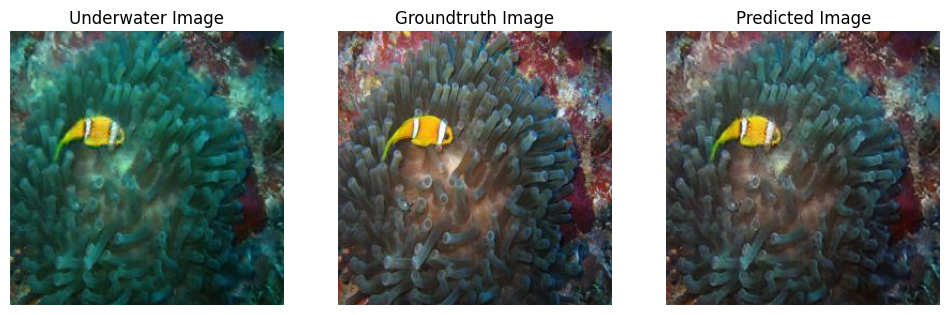

In [86]:
test_x_image_path = train_x_paths[IMAGE_IDX]
test_y_image_path = train_y_paths[IMAGE_IDX]

x_test_img = preprocess_image(test_x_image_path)
y_test_img = preprocess_image(test_y_image_path)
predicted_image = model.predict(np.expand_dims(x_test_img,axis=0),verbose=0)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].set_title("Underwater Image")
axes[1].set_title("Groundtruth Image")
axes[2].set_title("Predicted Image")

axes[0].imshow(x_test_img)
axes[1].imshow(y_test_img)
axes[2].imshow(predicted_image)

save_image_path = os.path.join(save_folder,f'model_prediction_{IMAGE_IDX}.png')
plt.savefig(save_image_path,dpi=300)
plt.show()

In [87]:
feature_output = selected_model.predict(np.expand_dims(x_test_img,axis=0),verbose=0)
print(feature_output[0].shape)

(1, 256, 256, 64)


#### **Layers Visualization**

block1_conv2 (1, 256, 256, 64)


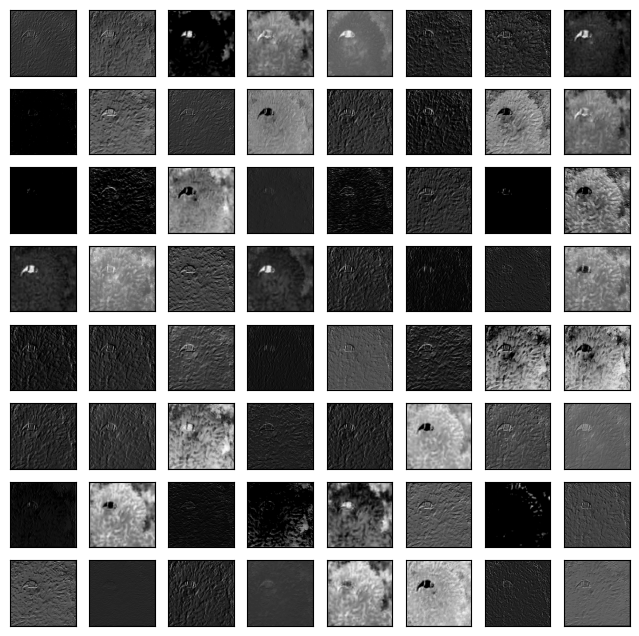

block1_pool (1, 128, 128, 64)


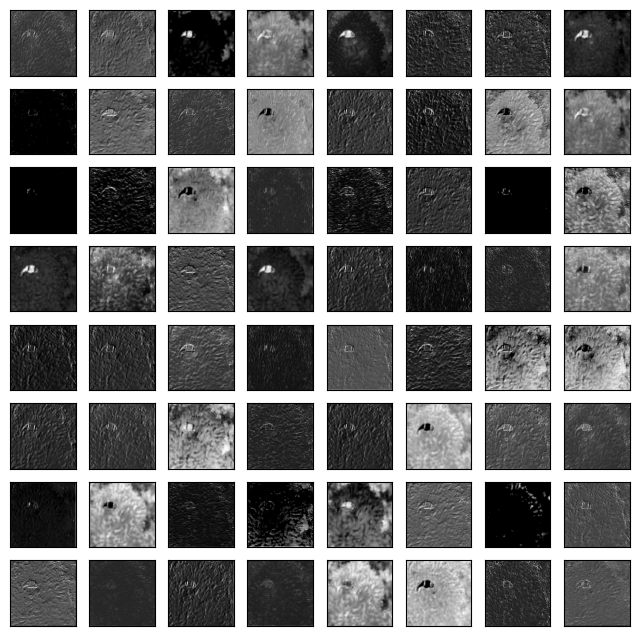

block2_conv2 (1, 128, 128, 128)


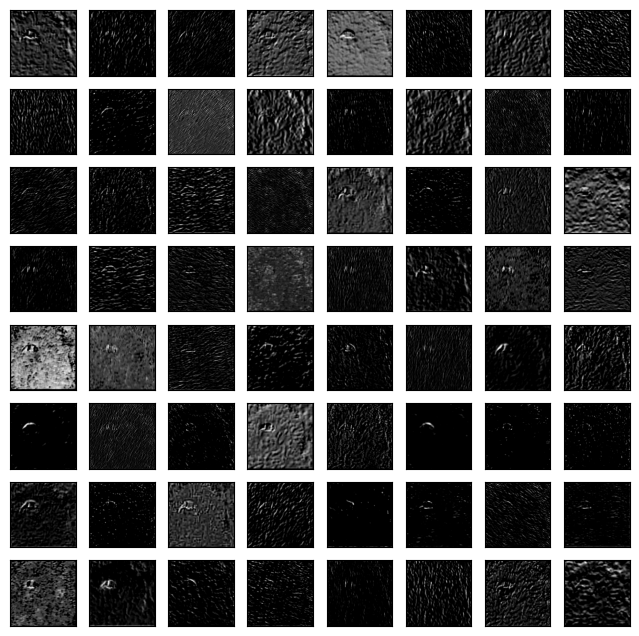

block2_pool (1, 64, 64, 128)


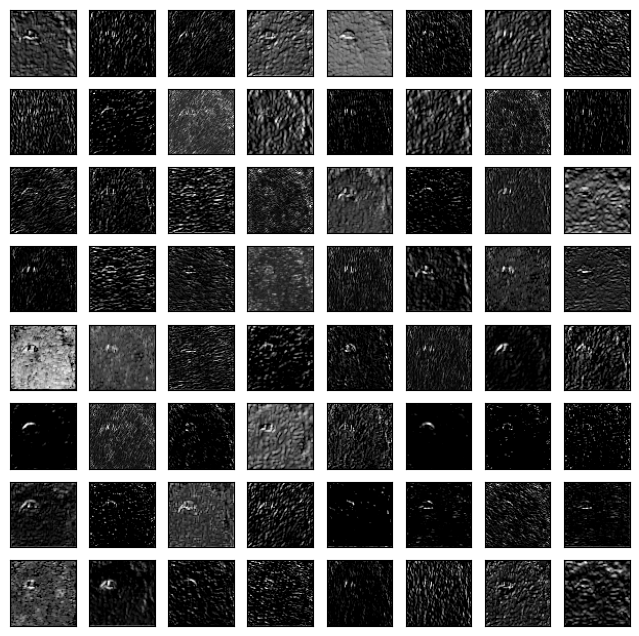

block3_conv3 (1, 64, 64, 256)


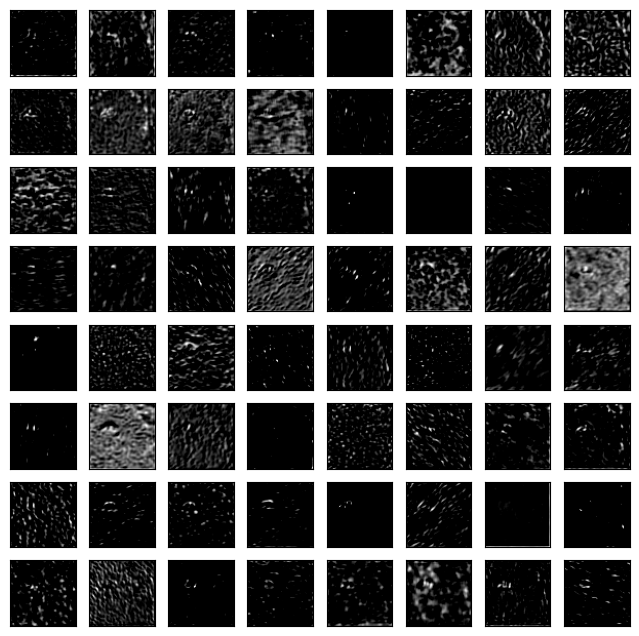

block3_pool (1, 32, 32, 256)


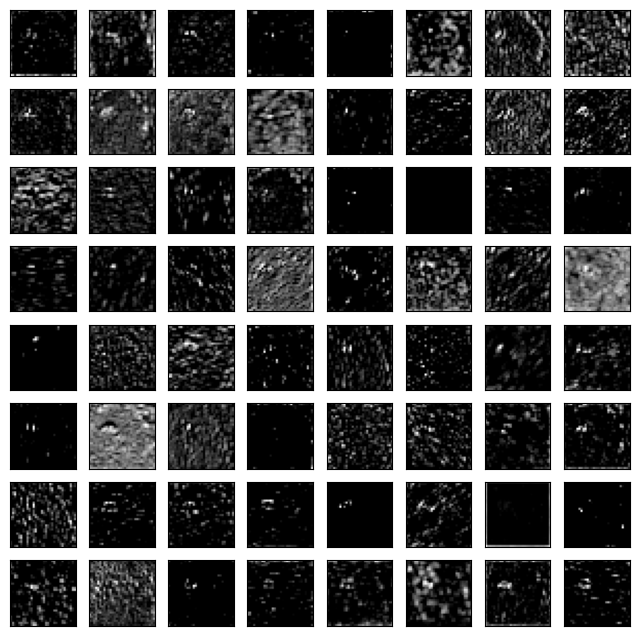

block4_conv3 (1, 32, 32, 512)


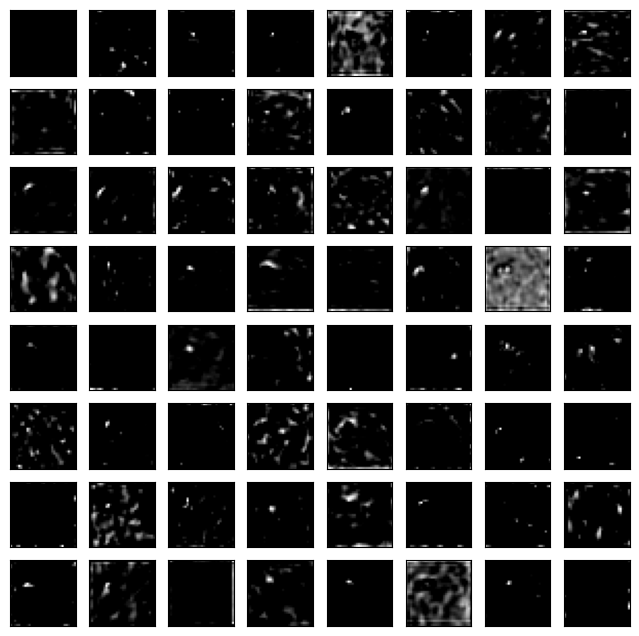

block4_pool (1, 16, 16, 512)


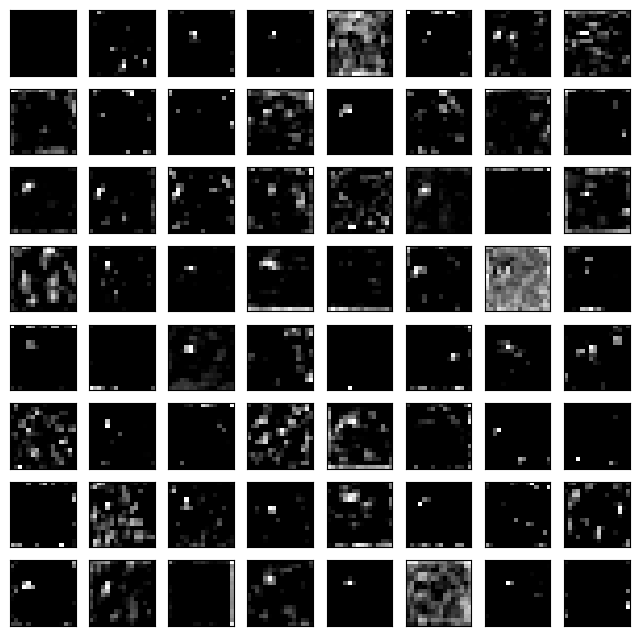

block5_conv3 (1, 16, 16, 512)


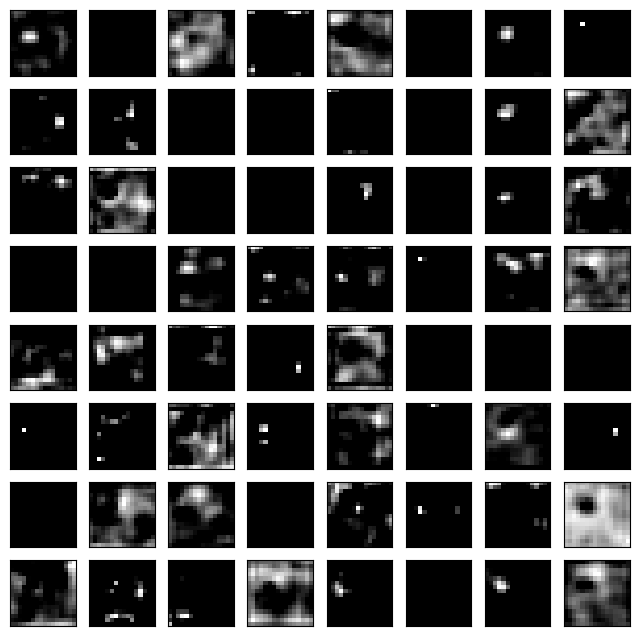

concatenate_3 (1, 32, 32, 2)
conv2d_transpose (1, 32, 32, 512)


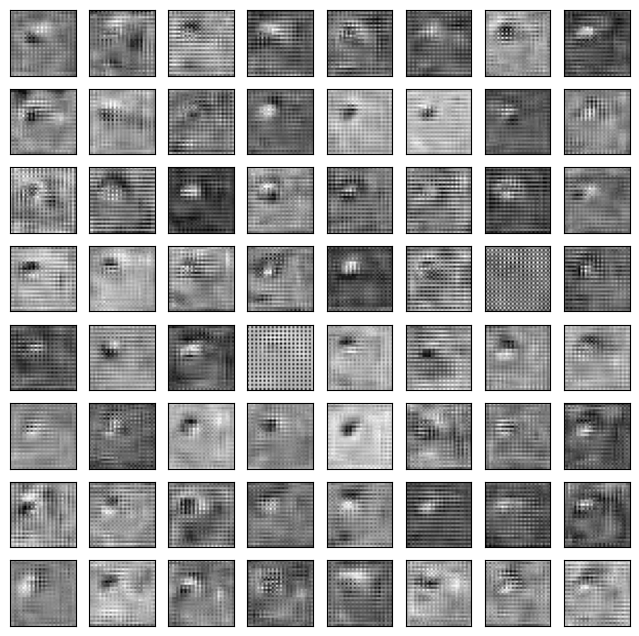

concatenate_4 (1, 32, 32, 1024)


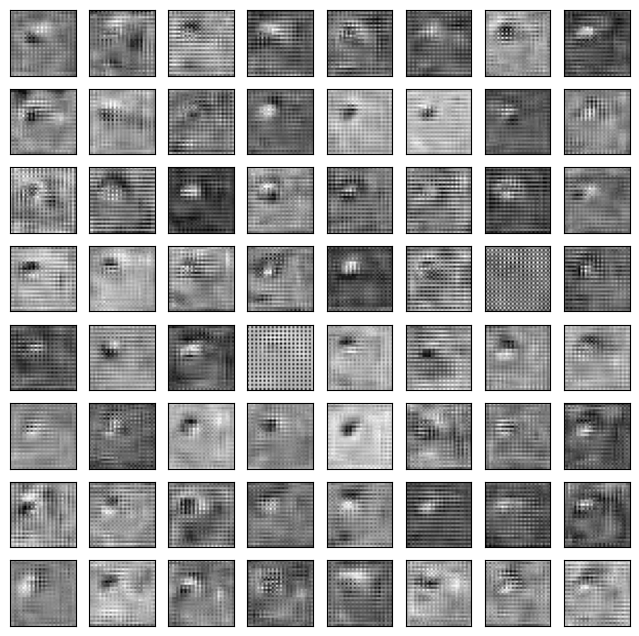

concatenate_2 (1, 64, 64, 2)
conv2d_transpose_1 (1, 64, 64, 256)


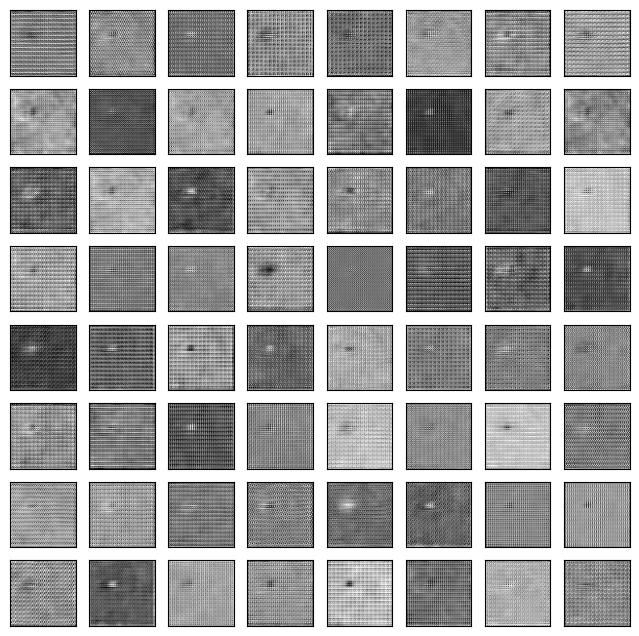

concatenate_5 (1, 64, 64, 512)


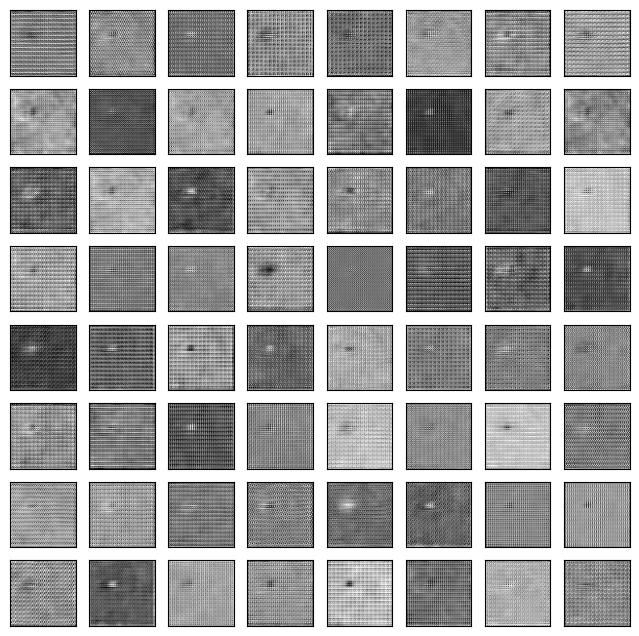

concatenate_1 (1, 128, 128, 2)
conv2d_transpose_2 (1, 128, 128, 128)


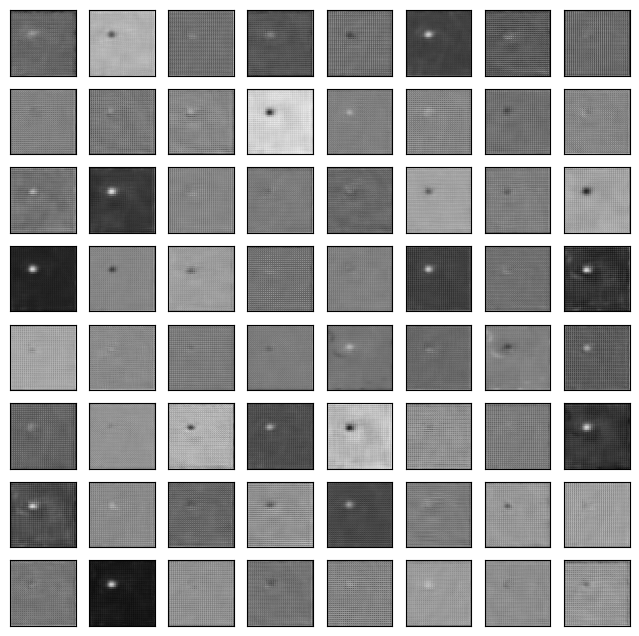

concatenate_6 (1, 128, 128, 256)


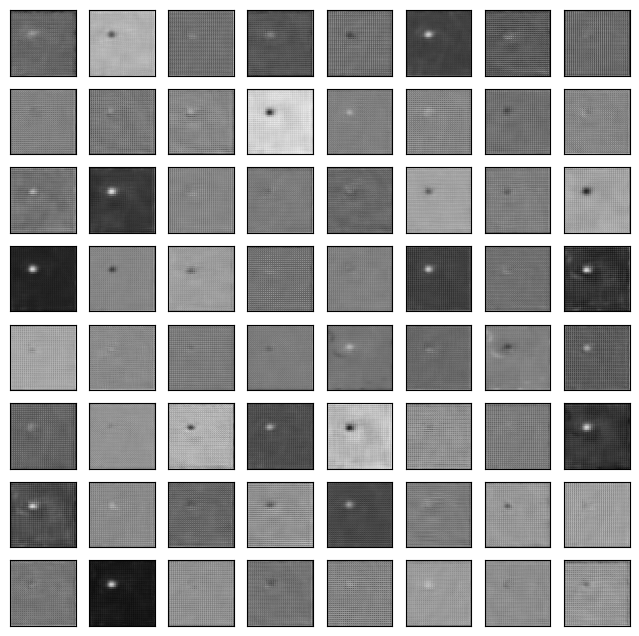

concatenate (1, 256, 256, 2)
conv2d_transpose_3 (1, 256, 256, 64)


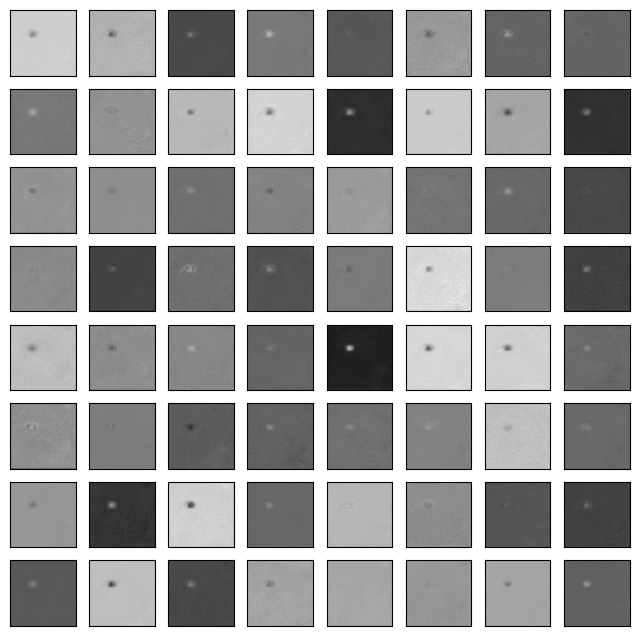

concatenate_7 (1, 256, 256, 128)


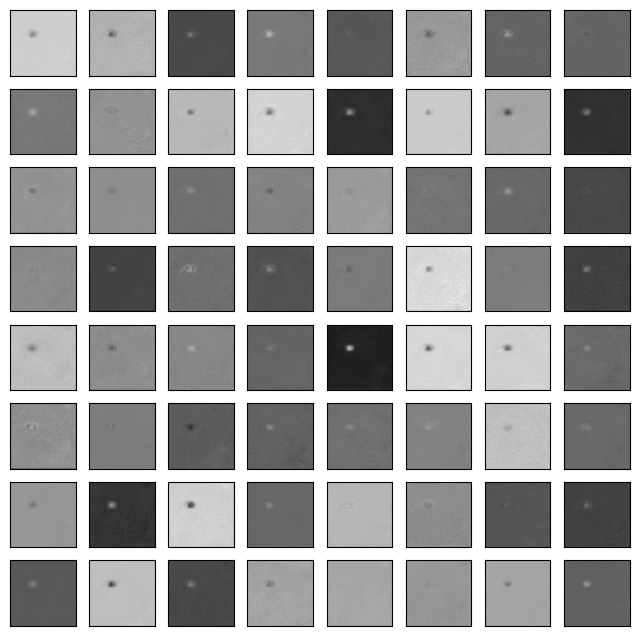

In [88]:
columns = 8
rows    = 8
for i,feature in enumerate(feature_output):
    layer_name = selected_layers[i]
    print(layer_name, feature.shape)
    
    if feature.shape[3] == 2: # to skip concatenate layers in the attention unit
        continue

    fig=plt.figure(figsize=(8, 8));
    for n in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, n)
        fig.set_xticks([])
        fig.set_yticks([])
        plot_feature = feature[0,:, :, n-1]
        plt.imshow(plot_feature, cmap='gray')

  
    save_image_path = os.path.join(save_folder,f'{layer_name}.png')
    plt.savefig(save_image_path, bbox_inches='tight', pad_inches=0)
    plt.show()